In [1]:
import jax
from scipy.integrate import odeint
import matplotlib.pyplot as plt
import numpy as np
import jax.numpy as jnp
import flax.linen as nn
from typing import Sequence, Union
import lib
from sklearn.cluster import KMeans
import sklearn
import optax
from tqdm import tqdm

import lib

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [2]:
time_delay_dim = 10
time_delay = 5
time_range = (0, 1200, 0.02)
n_centers = 500

In [3]:
n_sins = 100
np.random.seed(2308)
periods = np.random.uniform(5, 50, n_sins)
coeffs = np.random.uniform(0, 1, n_sins)
phases = np.random.uniform(0, 1, n_sins)*2*np.pi
stimulus_train = lib.stimulus.sinusoidals_stimulus(time_range, amplitude=30, periods=periods, coeffs=coeffs, phases=phases)

neuron_train = lib.neuron.single_neuron_odeint(time_range, stimulus_train.stimulus_list, neuron_initial_state=[0, 0, 0, 0])
neuron_train.generate_sol()

In [4]:
drop_first_n_points = 5000
neuron_train.sol = neuron_train.sol[drop_first_n_points:]
stimulus_train.stimulus_list = stimulus_train.stimulus_list[drop_first_n_points:]

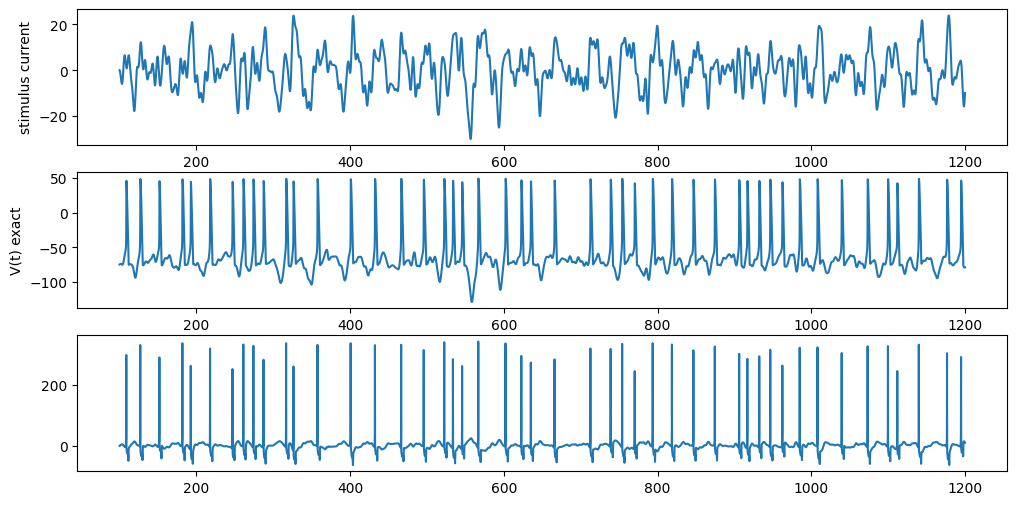

In [5]:
fig, axes = plt.subplots(3, 1,  figsize=(12, 6))

axes[0].plot(np.arange(*time_range)[drop_first_n_points:], stimulus_train.stimulus_list)
axes[0].set_ylabel("stimulus current")
axes[1].plot(np.arange(*time_range)[drop_first_n_points:], neuron_train.sol[:, 0])
axes[1].set_xlabel("time (ms)")
axes[1].set_ylabel("V(t) exact")
axes[2].plot(np.arange(*time_range)[drop_first_n_points:-1], (neuron_train.sol[1:, 0]-neuron_train.sol[:-1, 0])/2/0.02 - stimulus_train.stimulus_list[:-1])

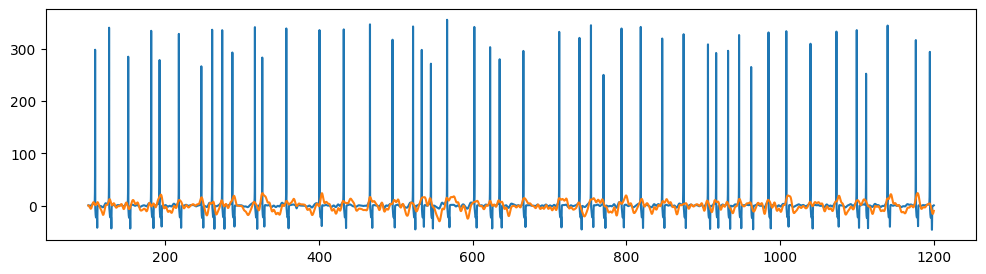

In [6]:
plt.figure(figsize=(12, 3))
plt.plot(np.arange(*time_range)[drop_first_n_points:-1], (neuron_train.sol[1:, 0]-neuron_train.sol[:-1, 0])/2/0.02)
plt.plot(np.arange(*time_range)[drop_first_n_points:-1], stimulus_train.stimulus_list[:-1])

In [7]:
class train_by_regression1():
    """training by doing linear/ridge regression"""
    """return (weights_rbf, weights_leak, weight_C)"""
    def __init__(self, centers, voltage_list, current_list, time_delay, time_delay_dim, time_spacing, beta, R) -> None:
        self.centers = centers # (n_centers, time_delay_dim)
        self.voltage_list = voltage_list
        self.current_list = current_list
        self.time_delay = time_delay
        self.time_delay_dim = time_delay_dim
        self.time_spacing = time_spacing
        self.beta = beta
        self.R = R # R = 1/sigma^2
        self.X = None
        self.Y = None

        self._pre_processing()

    def _pre_processing(self):
        first_usable_t_idx = self.time_delay*(self.time_delay_dim-1) # the first point that can be used for training.
        tmp_v = jnp.array([jnp.roll(self.voltage_list, -i*self.time_delay) for i in range(self.time_delay_dim)]).T
        tmp_v = tmp_v[:-1-first_usable_t_idx, :]
        tmp_delta_v = self.voltage_list[first_usable_t_idx+1:] - self.voltage_list[first_usable_t_idx:-1]
        tmp_i = (self.current_list + jnp.roll(self.current_list, -1))/2
        tmp_i = tmp_i[first_usable_t_idx:-1]

        self.X = jax.vmap(self._get_basis, in_axes=(0, 0))(tmp_v, tmp_delta_v/self.time_spacing)
        self.Y = tmp_i

    def _get_basis(self, time_delay_Vs, dVdt):
        diff = self.centers - time_delay_Vs
        rbfs = jnp.exp(-np.sum(diff**2, axis=-1)*self.R/2)
        leaky_terms = jnp.array([1, time_delay_Vs[-1]])
        return jnp.concatenate((-rbfs, -leaky_terms, jnp.array([dVdt])))


    def get_weights(self, solver="auto"):
        ridge = sklearn.linear_model.Ridge(alpha=self.beta, fit_intercept=False, solver=solver)
        self.ridge = ridge.fit(self.X, self.Y)
        self.score = ridge.score(self.X, self.Y)
        weight_C = ridge.coef_[-1]
        weights_leak = ridge.coef_[-3:-1]
        weights_rbf = ridge.coef_[:-3]
        return (weights_rbf, weights_leak, weight_C)
    
    def get_error_list(self):
        return self.Y - self.X @ self.ridge.coef_
    
class train_by_regression2(train_by_regression1):
    """return (weights_rbf, weights_leak, weight_C_inverse)"""
    def _pre_processing(self):
        first_usable_t_idx = self.time_delay*(self.time_delay_dim-1) # the first point that can be used for training.
        tmp_v = jnp.array([jnp.roll(self.voltage_list, -i*self.time_delay) for i in range(self.time_delay_dim)]).T
        tmp_v = tmp_v[:-1-first_usable_t_idx, :]
        tmp_delta_v = self.voltage_list[first_usable_t_idx+1:] - self.voltage_list[first_usable_t_idx:-1]
        tmp_i = (self.current_list + jnp.roll(self.current_list, -1))/2
        tmp_i = tmp_i[first_usable_t_idx:-1]

        self.X = jax.vmap(self._get_basis, in_axes=(0, 0))(tmp_v, tmp_i)
        self.Y = tmp_delta_v/self.time_spacing

    def _get_basis(self, time_delay_Vs, I_avg):
        diff = self.centers - time_delay_Vs
        rbfs = jnp.exp(-np.sum(diff**2, axis=-1)*self.R/2)
        leaky_terms = jnp.array([1, time_delay_Vs[-1]])
        return jnp.concatenate((rbfs, leaky_terms, jnp.array([I_avg])))
    
class train_by_regression3():
    """training by doing linear/ridge regression"""
    """return (weights_rbf, weights_leak)"""
    def __init__(self, centers, voltage_list, current_list, time_delay, time_delay_dim, time_spacing, beta, R) -> None:
        self.centers = centers # (n_centers, time_delay_dim)
        self.voltage_list = voltage_list
        self.current_list = current_list
        self.time_delay = time_delay
        self.time_delay_dim = time_delay_dim
        self.time_spacing = time_spacing
        self.beta = beta
        self.R = R # R = 1/sigma^2
        self.X = None
        self.Y = None
        self.weight_C = 1.0

        self._pre_processing()

    def _pre_processing(self):
        first_usable_t_idx = self.time_delay*(self.time_delay_dim-1) # the first point that can be used for training.
        tmp_v = jnp.array([jnp.roll(self.voltage_list, -i*self.time_delay) for i in range(self.time_delay_dim)]).T
        tmp_v = tmp_v[:-1-first_usable_t_idx, :]
        tmp_delta_v = self.voltage_list[first_usable_t_idx+1:] - self.voltage_list[first_usable_t_idx:-1]
        tmp_i = (self.current_list + jnp.roll(self.current_list, -1))/2
        tmp_i = tmp_i[first_usable_t_idx:-1]

        self.X = jax.vmap(self._get_basis, in_axes=(0, ))(tmp_v)
        self.Y = tmp_delta_v/self.time_spacing - tmp_i/self.weight_C

    def _get_basis(self, time_delay_Vs):
        diff = self.centers - time_delay_Vs
        rbfs = jnp.exp(-np.sum(diff**2, axis=-1)*self.R/2)
        leaky_terms = jnp.array([1, time_delay_Vs[-1]])
        return jnp.concatenate((rbfs, leaky_terms))


    def get_weights(self, solver="auto"):
        ridge = sklearn.linear_model.Ridge(alpha=self.beta, fit_intercept=False, solver=solver)
        self.ridge = ridge.fit(self.X, self.Y)
        self.score = ridge.score(self.X, self.Y)
        weights_leak = ridge.coef_[-2:]
        weights_rbf = ridge.coef_[:-2]
        return (weights_rbf, weights_leak, self.weight_C)
    
    def get_error_list(self):
        return self.Y - self.X @ self.ridge.coef_

(0.0, 10000.0)

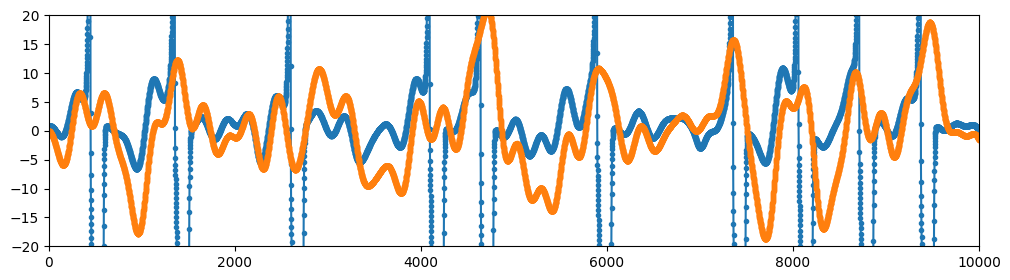

In [8]:
plt.figure(figsize=(12, 3))
plt.plot((neuron_train.sol[1:, 0] - neuron_train.sol[:-1, 0])/0.02, marker=".")
plt.plot(stimulus_train.stimulus_list[1:], marker=".")
plt.ylim(-20, 20)
plt.xlim(0, 10000)

In [ ]:
"""get centers and R"""
centers, R = lib.train.get_centers_and_R(neuron_train.sol[:, 0], time_delay, time_delay_dim, n_centers, n_neighbors=8)
for i in range(len(centers)):
    circle = plt.Circle((centers[i, 1], centers[i, 0]), radius=np.sqrt(1/R[i]), alpha=0.2, edgecolor='none')
    plt.gca().add_artist(circle)
plt.scatter(centers[:, 1], centers[:, 0], s=2, c="red")

In [9]:
"""RBF part training by regression"""
beta = 0
# regression = lib.train.train_by_regression(centers, neuron_train.sol[:, 0], stimulus_train.stimulus_list, time_delay, time_delay_dim, time_spacing=time_range[-1], beta=beta, R=R)
regression = train_by_regression3(centers, neuron_train.sol[:, 0], stimulus_train.stimulus_list, time_delay, time_delay_dim, time_spacing=time_range[-1], beta=beta, R=R)
(weights_rbf, weights_leak, weight_C) = regression.get_weights(solver="sparse_cg")

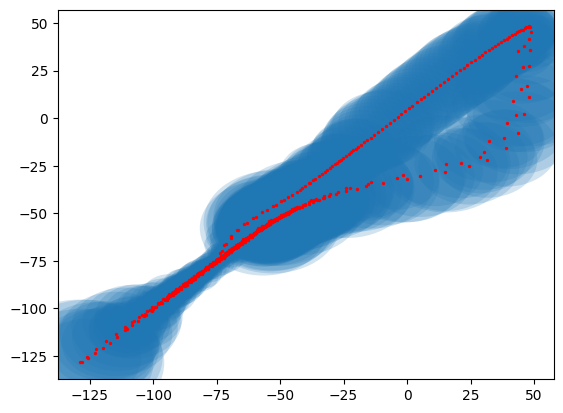

In [10]:
for i in range(len(centers)):
    circle = plt.Circle((centers[i, 1], centers[i, 0]), radius=np.sqrt(1/R[i]), alpha=0.2, edgecolor='none')
    plt.gca().add_artist(circle)
plt.scatter(centers[:, 1], centers[:, 0], s=2, c="red")

In [11]:
print("C: ", weight_C, "\nA+BV, A, B:", weights_leak)
error_list = regression.get_error_list()
error_list = error_list*time_range[-1]/weight_C
print("max abs error:", np.max(np.abs(error_list)))
print("mean abs error:", np.mean(np.abs(error_list)))

C:  1.0 
A+BV, A, B: [-4.6534967 -0.587967 ]
max abs error: 1.2297412
mean abs error: 0.055424497


In [12]:
mlp = lib.models.mlps()
pred_model = lib.models.prediction_model(time_range[-1], R, centers, weights_rbf, mlp, weights_leak, weight_C)
params = pred_model.init(jax.random.PRNGKey(0), jnp.zeros(time_delay_dim,), jnp.zeros(time_delay_dim, ))
params0 = params

In [13]:
BP_train_fast = lib.train.train_by_BP(stimulus_train.stimulus_list, neuron_train.sol[:, 0], pred_model, time_delay, time_delay_dim, time_delay, time_delay_dim, time_range, batch_size=5000)
BP_train_fast.get_batches(jax.random.PRNGKey(123))
optimizer = optax.adam(learning_rate=0.001, b1=0.9, b2=0.9)
params = BP_train_fast.run(params, 2000, optimizer)

100%|██████████| 2000/2000 [01:11<00:00, 28.05it/s, loss=0.0002841099] 


In [20]:
BP_train_slow = lib.train.train_by_BP(stimulus_train.stimulus_list, neuron_train.sol[:, 0], pred_model, time_delay, time_delay_dim, time_delay, time_delay_dim, time_range, batch_size=54000)
BP_train_slow.get_batches(jax.random.PRNGKey(123))
optimizer = optax.adam(learning_rate=0.001, b1=0.9, b2=0.9)
params = BP_train_slow.run(params, 2000, optimizer)

100%|██████████| 2000/2000 [09:01<00:00,  3.70it/s, loss=9.3537994e-05] 


Text(0.5, 0, 'epoch')

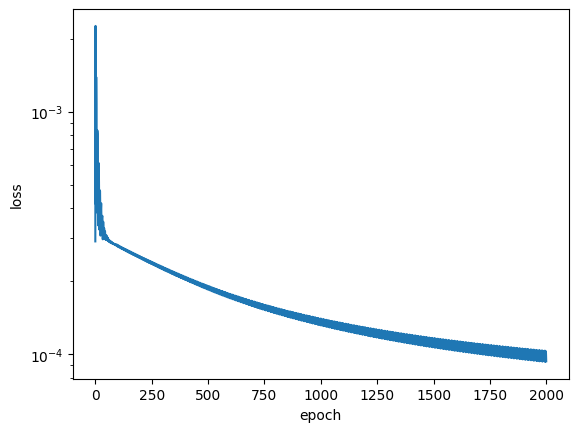

In [23]:
"""plot loss curve"""
plt.plot(BP_train_fast.loss_list[0:], label="fast training period")
plt.plot(BP_train_slow.loss_list[0:], label="slow training period")
plt.yscale("log")
plt.ylabel("loss")
plt.xlabel("epoch")

In [25]:
"""data prepartion for prediction"""
n_prediction_steps = 20000
initial_piece_len = time_delay*(time_delay_dim-1) + 1
prediction_start_after = 1100

# test data set
time_spacing = time_range[2]
time_range_test = (0, int((drop_first_n_points + 2*initial_piece_len + n_prediction_steps + prediction_start_after)*time_spacing)+1, time_spacing)

# ------------------ test data 1 --------------------
n_sins = 100
np.random.seed(2033)
periods_test1 = np.random.uniform(5, 50, n_sins)
coeffs_test1 = np.random.uniform(0, 1, n_sins)
phases_test1 = np.random.uniform(0, 1, n_sins)*2*np.pi
stimulus_test1 = lib.stimulus.sinusoidals_stimulus(time_range, amplitude=30, periods=periods_test1, coeffs=coeffs_test1, phases=phases_test1)

test_neuron1 = lib.neuron.single_neuron_odeint(time_range, stimulus_test1.stimulus_list, [-10, 0, 0.8, 0.5])
test_neuron1.generate_sol()
test_neuron1.sol = test_neuron1.sol[drop_first_n_points:]
stimulus_test1.stimulus_list = stimulus_test1.stimulus_list[drop_first_n_points:]
initial_piece_test1 = test_neuron1.sol[prediction_start_after:prediction_start_after+initial_piece_len, 0]
stimulus_list_test1 = stimulus_test1.stimulus_list[prediction_start_after+initial_piece_len:]

# ------------------ test data 2 --------------------
n_sins = 100
np.random.seed(0)
periods_test2 = np.random.uniform(5, 50, n_sins)
periods_test2 = periods_test2[np.argsort(np.abs(periods_test2))]
coeffs_test2 = np.random.uniform(0, 1, n_sins)
coeffs_test2 = coeffs_test2[np.argsort(np.abs(coeffs_test2))]
phases_test2 = np.random.uniform(0, 1, n_sins)*2*np.pi
stimulus_test2 = lib.stimulus.sinusoidals_stimulus(time_range, amplitude=30, periods=periods_test2, coeffs=coeffs_test2, phases=phases_test2)

test_neuron2 = lib.neuron.single_neuron_odeint(time_range, stimulus_test2.stimulus_list, [-10, 0, 0.8, 0.5])
test_neuron2.generate_sol()
test_neuron2.sol = test_neuron2.sol[drop_first_n_points:]
stimulus_test2.stimulus_list = stimulus_test2.stimulus_list[drop_first_n_points:]
initial_piece_test2 = test_neuron2.sol[prediction_start_after:prediction_start_after+initial_piece_len, 0]
stimulus_list_test2 = stimulus_test2.stimulus_list[prediction_start_after+initial_piece_len:]

# ------------------ test data 3 --------------------
n_sins = 100
np.random.seed(0)
periods_test3 = np.random.uniform(5, 50, n_sins)
periods_test3 = periods_test3[-np.argsort(np.abs(periods_test3))]
coeffs_test3 = np.random.uniform(0, 1, n_sins)
coeffs_test3 = coeffs_test3[np.argsort(np.abs(coeffs_test3))]
phases_test3 = np.random.uniform(0, 1, n_sins)*2*np.pi
stimulus_test3 = lib.stimulus.sinusoidals_stimulus(time_range, amplitude=30, periods=periods_test3, coeffs=coeffs_test3, phases=phases_test3)

test_neuron3 = lib.neuron.single_neuron_odeint(time_range, stimulus_test3.stimulus_list, [-10, 0, 0.8, 0.5])
test_neuron3.generate_sol()
test_neuron3.sol = test_neuron3.sol[drop_first_n_points:]
stimulus_test3.stimulus_list = stimulus_test3.stimulus_list[drop_first_n_points:]
initial_piece_test3 = test_neuron3.sol[prediction_start_after:prediction_start_after+initial_piece_len, 0]
stimulus_list_test3 = stimulus_test3.stimulus_list[prediction_start_after+initial_piece_len:]

# ------------------ test data 4 --------------------
stimulus_test4 = lib.stimulus.lorenz1963_stimulus(time_range=time_range, initial_state=[-3.3, -3.0, 22], rescale_factor=1.5)
stimulus_test4.get_stimulus_list()
test_neuron4 = lib.neuron.single_neuron_odeint(time_range, stimulus_test4.stimulus_list, [-10, 0, 0.8, 0.5])
test_neuron4.generate_sol()
test_neuron4.sol = test_neuron4.sol[drop_first_n_points:]
stimulus_test4.stimulus_list = stimulus_test4.stimulus_list[drop_first_n_points:]
initial_piece_test4 = test_neuron4.sol[prediction_start_after:prediction_start_after+initial_piece_len, 0]
stimulus_list_test4 = stimulus_test4.stimulus_list[prediction_start_after+initial_piece_len:]

batch_initial_piece = jnp.array([initial_piece_test1, initial_piece_test2, initial_piece_test3, initial_piece_test4])
batch_stimulus_list_len = min(len(stimulus_list_test1), len(stimulus_list_test2), len(stimulus_list_test3), len(stimulus_list_test4))
batch_stimulus_list = jnp.array([stimulus_list_test1[:batch_stimulus_list_len], stimulus_list_test2[:batch_stimulus_list_len], stimulus_list_test3[:batch_stimulus_list_len], stimulus_list_test4[:batch_stimulus_list_len]])

In [27]:
class time_series_prediction():
    def __init__(self, model: lib.models.prediction_model, time_delay_V: int, time_delay_dim_V: int, time_delay_I: int, time_delay_dim_I: int, stimulus_list: Sequence[float], initial_piece_V: Sequence[float]) -> None:
        """
        `stimulus_list` and `initial_piece_V` can be 1d or 2d (for batching) arrays. The last dimension should be the time dimension. 
        `stimulus_list` and `initial_piece_V` don't need to have the same dimension, but make sure that they are aligned in time, i.e., `stimulus_list[..., 0]` and `initial_piece_V[..., 0]` are the current and voltage at time 0 respectively. 
        The result of prediction is stored in `prediction_list`, it will be aligned with the `stimulus_list[..., 0]`. 
        `t0` is the start of the prediction. `prediction_list[..., t0+1]` will store the result of the first prediction. `t0` is automatically calculated. 
        The length of `initial_piece_V` should be `t0+1`. If it is longer, the extra part will be automatically dropped. 
        """
        self.model = model

        self.time_delay_V, self.time_delay_dim_V = time_delay_V, time_delay_dim_V
        self.time_delay_I, self.time_delay_dim_I = time_delay_I, time_delay_dim_I
        self.t0 = max(time_delay_V*(time_delay_dim_V-1), time_delay_I*(time_delay_dim_I-1))
        # the index corresponding to the start of the prediction. self.prediction_list[sellf.t0+1] (defined below) should store the first predicted voltage. 

        initial_piece_V = jnp.atleast_2d(initial_piece_V)[..., :self.t0+1] # t0 + 1 should be the length of the initial piece.
        stimulus_list = jnp.atleast_2d(stimulus_list)
        self.batch_avg_i = ((stimulus_list + jnp.roll(stimulus_list, -1, axis=-1))/2)[..., :-1]

        stimulus_len = stimulus_list.shape[-1]
        self.prediction_list = np.zeros(stimulus_list.shape)
        self.prediction_list[..., :self.t0+1] = initial_piece_V

    def run(self, params, n_steps):
        state_indices_V = np.array([self.t0 - (self.time_delay_dim_V-1-n)*self.time_delay_V for n in range(self.time_delay_dim_V)]) 
        state_indices_I = np.array([self.t0 - (self.time_delay_dim_I-1-n)*self.time_delay_I for n in range(self.time_delay_dim_I)]) 
        n_steps = min(n_steps, self.prediction_list.shape[-1] - self.t0 - 1)
        for i in tqdm(range(n_steps)):
            vs = jnp.array(self.prediction_list[..., state_indices_V])
            avg_is = jnp.array(self.batch_avg_i[..., state_indices_I])
            next_v = self.model.apply(params, vs, avg_is)
            self.prediction_list[..., i + self.t0 + 1] = next_v.reshape((-1, ))
            state_indices_V = state_indices_V + 1
            state_indices_I = state_indices_I + 1

In [28]:
"""prediction with ann + current history"""
pred_run1_batch = time_series_prediction(pred_model, time_delay, time_delay_dim, time_delay, time_delay_dim, batch_stimulus_list, batch_initial_piece)
pred_run1_batch.run(params, n_steps=6000)

100%|██████████| 6000/6000 [10:04<00:00,  9.93it/s]


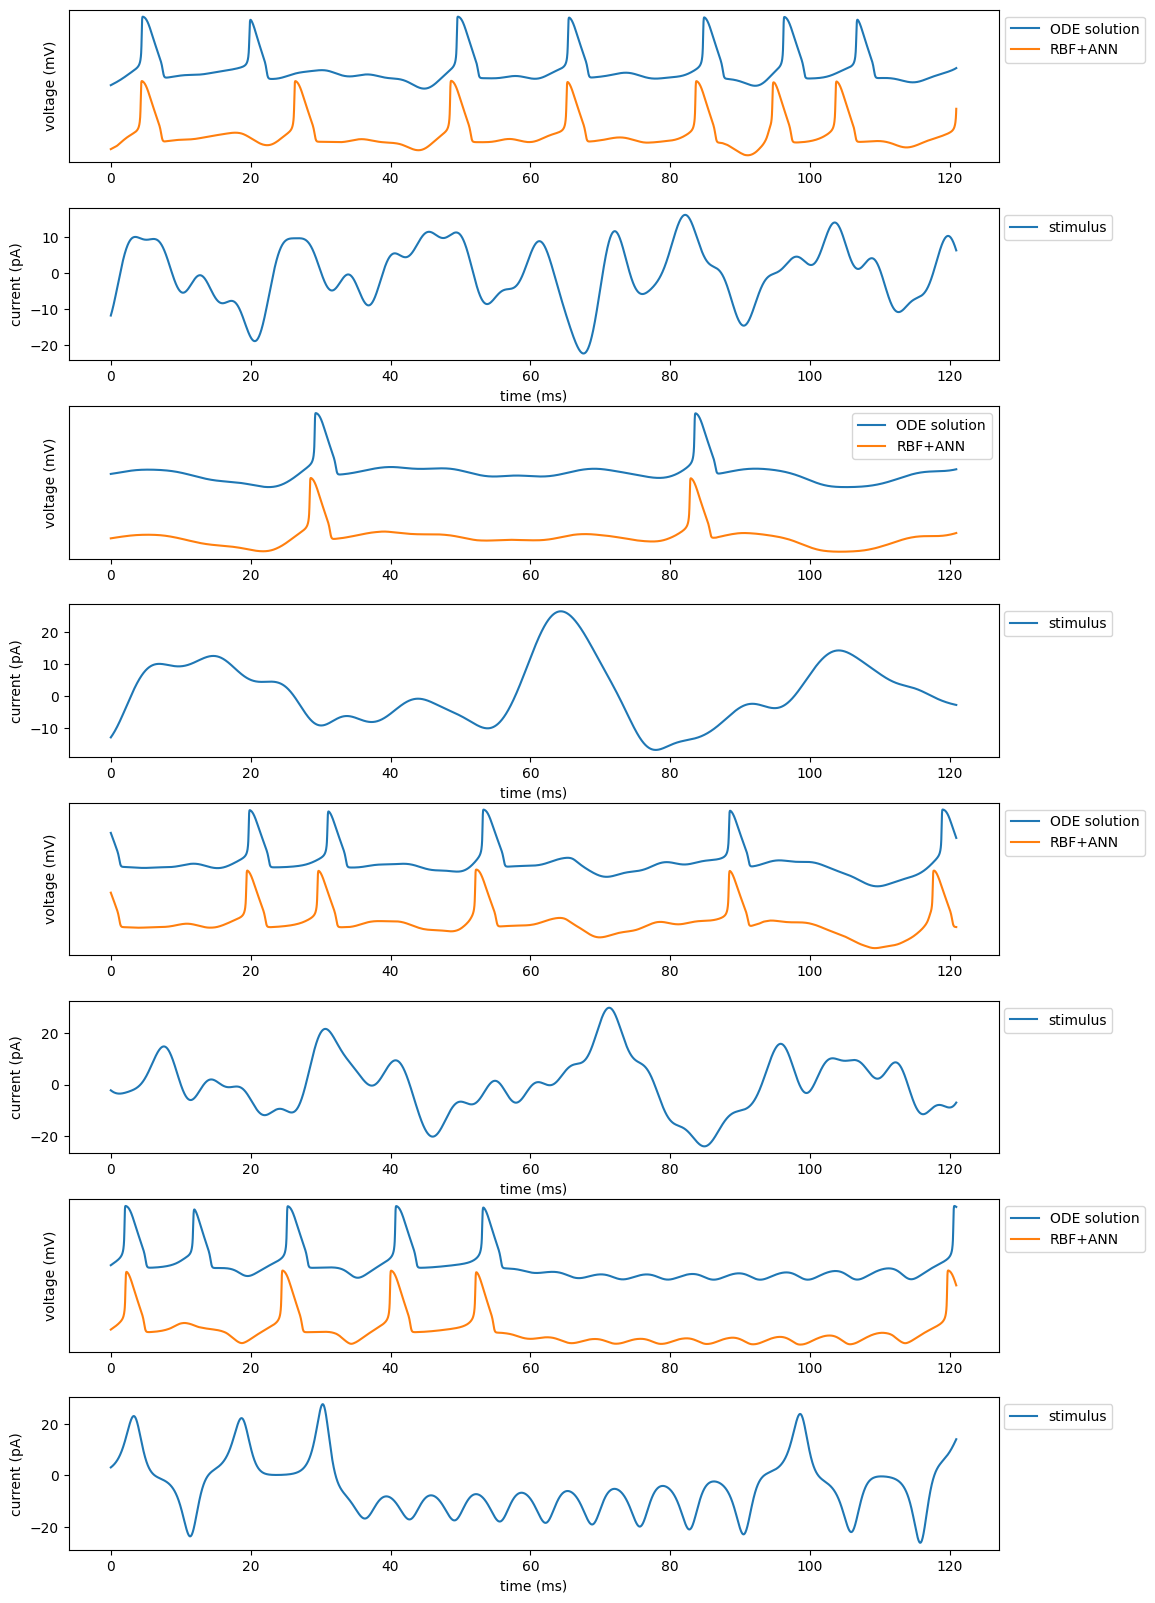

In [29]:
"""plot tests results"""
n_tests = 4
test_neuron_list = [test_neuron1, test_neuron2, test_neuron3, test_neuron4]

start = initial_piece_len + -initial_piece_len 
end = initial_piece_len + 6000

fig, axes = plt.subplots(2*n_tests, 1, figsize=(12, 5*n_tests))
fig.subplots_adjust(hspace=0.3, wspace=0.3)
for i in range(n_tests):
    axes[2*i].plot(np.arange(0, (end-start)*time_spacing, time_spacing), test_neuron_list[i].sol[prediction_start_after+start: prediction_start_after+end, 0]+0, label="ODE solution")
    axes[2*i].plot(np.arange(0, (end-start)*time_spacing, time_spacing), pred_run1_batch.prediction_list[i, start:end]-130, label="RBF+ANN")
    # axes[2*i].plot(np.arange(0, (end-start)*time_spacing, time_spacing), pred_run0_batch.prediction_list[i, start:end]-260, label="RBF only")
    axes[2*i].set_yticks([])
    axes[2*i].set_ylabel("voltage (mV)")
    # axes[2*i].set_ylim(-440, 100)
    axes[2*i].legend(bbox_to_anchor=(1,1))
    
    axes[2*i+1].plot(np.arange(0, (end-start)*time_spacing, time_spacing), batch_stimulus_list[i, prediction_start_after+start: prediction_start_after+end], label="stimulus")
    axes[2*i+1].set_xlabel("time (ms)")
    axes[2*i+1].set_ylabel("current (pA)")
    axes[2*i+1].legend(bbox_to_anchor=(1.13,1))